# This is a notebook that will create a series of .dat files that will be used to verify future TESSPoint versions

### Using the footprint of a ccd (e.g. outside pixels), we will:
 - We will start using the current TESSPoint tess_stars2px.py script
 - Take a CCD "footprint" that is roughly the outer edge of CCD pixels
 - Transform X, Y Footprint ()pixels  -> pix2radec ->RA, DEC pixels * for every Sector, Camera, CCD
 - Transform RA, DEC Footprint pixels -> radec2pix -> X, Y Footprint pixels * for every Sector, Camera, CCD
 - We will then compare deviations between our starting and ending X, Y to make sure our transfroms are robust
 - These will be stored in a series of pix2radec & radec2pix *.dat files 
 - TESSPoint vectorize branch and future versions will benchmark xy->radec & radec->xy against these files

In [43]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import subprocess
import multiprocessing
from itertools import product

import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## First, lets create a footprint.  
footprint_input.dat is a text file output of the footprint() function from tesspoint-vectorize
recreating this here to verify and possibly adapt

In [44]:
def footprint(npoints=50):
    """Gets the column and row points for CCD edges"""
    column = np.hstack(
        [
            np.zeros(npoints),
            np.linspace(0, 2048, npoints),
            np.linspace(0, 2048, npoints),
            np.ones(npoints) * 2048,
        ]
    )
    row = np.hstack(
        [
            np.linspace(0, 2048, npoints),
            np.zeros(npoints),
            np.ones(npoints) * 2048,
            np.linspace(0, 2048, npoints),
        ]
    )
    return np.vstack([column, row]).T

## What does this footprint look like?

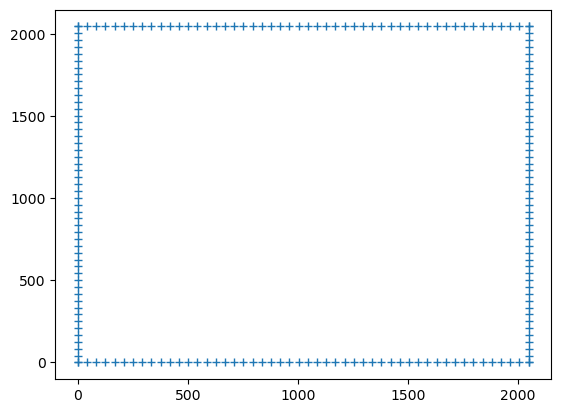

In [66]:
xy = footprint()
plt.plot(xy[:,0],xy[:,1],linestyle='None',marker='+')

Sector=1
Camera=0
CCD=0
pixfile="testfiles/TEST_radec2pix_Sec{:02d}_Cam{}_CCD{}_stars2px.dat".format(Sector,Camera,CCD)

# We're running into some less-than-robust transforms down below.  Are we literally tracing the edge of the CCD and is that causing problems?  Should we choose middle of the pixels?  eg 0.5, 0.5 -> 2047.5 x 2047.5?

In [2]:
footprint_file='footprint_input.dat'

In [3]:
footprint_df=pd.read_csv(footprint_file,delimiter=' ',names=['tic','x','y'],index_col=False)

In [4]:
footprint_df

,tic,x,y
0,0,0.0,0.000000
1,1,0.0,41.795918
2,2,0.0,83.591837
3,3,0.0,125.387755
4,4,0.0,167.183673
...,...,...,...
195,195,2048.0,1880.816327
196,196,2048.0,1922.612245
197,197,2048.0,1964.408163
198,198,2048.0,2006.204082


## I couldn't make tess_stars2xy.py work in reverse mode with an input file list
## Only like this:

In [5]:
%run -i tess_stars2px.py -r 1 0 4 1 1

105.8903224112561 -56.99246172298772


## So we'll have to do this the painfull way

- We will call tess_stars2px.py in reverse mode ("-r") for every entry in footprint 
- We will collate these results to create a file from that output
- We will do this for every Sector, Camera & CCD
- This is slow and painfull because I'm using subprocess to capture the output of the script
- So we will use multiprocess.pool to make this take hours and not a day
- multiprocess.pool doesn't like iterating functions to be defined in a notebook
    - so we have the below functions defined in testfun.py for use in pool
- This is ~ 3 hours on my laptop processing time wise

In [6]:
def create_test_array(ticlist,xlist,ylist,Sector, Camera, CCD):
    ra_return=[]
    dec_return=[]
    for tic, x, y in zip(ticlist, xlist, ylist):
        point=subprocess.run(["python","/Users/tapritc2/tessgi/tesspoint/tess-point/tess_stars2px.py",
                        "-r",str(Sector),str(Camera),str(CCD),str(x),str(y)],capture_output=True,text=True)
        ra_return.append(float(point.stdout.split(' ')[0]))
        dec_return.append(float(point.stdout.split(' ')[1]))
    return ticlist, ra_return, dec_return

def create_test_file(ticlist,xlist,ylist,Sector, Camera, CCD):
    tic, ra, dec = create_test_array(ticlist,xlist,ylist,Sector, Camera, CCD)
    f= open("testfiles/TEST_pix2radec_Sec{:02d}_Cam{}_CCD{}_stars2px.dat".format(Sector,Camera,CCD),'w')
    f.write('# TIC RA DEC \n')
    for t_out,ra_out,dec_out in zip (tic,ra, dec):
        f.write('{0} {1} {2} \n'.format(t_out,ra_out,dec_out))
    f.close()
    return

def multi_create_test_file(SectorCameraCCD):
    Sector, Camera, CCD = SectorCameraCCD
    footprint_file='footprint_input.dat'
    footprint_df=pd.read_csv(footprint_file,delimiter=' ',names=['tic','x','y'],index_col=False)
    create_test_file(footprint_df.tic.to_numpy(),footprint_df.x.to_numpy(),footprint_df.y.to_numpy(),
                     Sector, Camera, CCD)
    return True
from testfun import testprod, create_test_array, create_test_file, multi_create_test_file

## Here we will create our list of Sector/Camera/CCD Inputs that we will iterate across 
Using itertools.product to get every combination of sector/camera/ccd accross our lists

In [22]:
Camera_list=[1,2,3,4]
CCD_list=[1,2,3,4]
Sector_list = range(1,69)
inlist=list(product(Sector_list,Camera_list,CCD_list))

## Now we will execute or multiprocessing task group

In [30]:
from multiprocessing.pool import Pool
pool=Pool()
for result in pool.map(multi_create_test_file, inlist):
    print(result)
pool.close()

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


## Great, that seemed to work
Now, for each file, do the reverse

In [8]:
def create_reverse_file(SectorCameraCCD):
    Sector, Camera, CCD = SectorCameraCCD
    wcsfile="testfiles/TEST_pix2radec_Sec{0}_Cam{1}_CCD{2}_stars2px.dat".format(str(Sector),str(Camera),str(CCD))
    pixfile="testfiles/TEST_radec2pix_Sec{:02d}_Cam{}_CCD{}_stars2px.dat".format(Sector,Camera,CCD)
    point=subprocess.run(["python","/Users/tapritc2/tessgi/tesspoint/tess-point/tess_stars2px.py",
                        "-s",str(Sector),"-f",wcsfile,"-o",pixfile],capture_output=True,text=True)
    return


In [9]:
create_reverse_file((1,0,0))

In [14]:
from testfun import create_reverse_file
from multiprocessing.pool import Pool
pool=Pool()
for result in pool.map(create_reverse_file, inlist):
    print(result)
pool.close()

None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None


## Wow that's a lot faster.  Love it. 
One check we can do: footprint - radec2px for deviation  
Lets do max/median/standard deviation per coordinate / sector / camera / ccd

In [10]:
def calc_deviation_scc(SectorCameraCCD):
    Sector, Camera, CCD = SectorCameraCCD
    
    pixfile="testfiles/TEST_radec2pix_Sec{:02d}_Cam{}_CCD{}_stars2px.dat".format(Sector,Camera,CCD)
    footprint_file='footprint_input.dat'
    
    footprint_df=pd.read_csv(footprint_file,delimiter=' ',names=['tic','x','y'],index_col=False)
    final_df=pd.read_csv(pixfile,names=['tic','ra','dec','el','ela','s','c','ccd','x','y','edge'],
                         index_col=0, skiprows=16,delimiter="|" )
    
    idx = final_df.index.intersection(footprint_df.index)
    dx=abs(final_df.loc[idx, 'x'] - footprint_df.loc[idx, 'x'])
    dy=abs(final_df.loc[idx, 'y'] - footprint_df.loc[idx, 'y'])
    return len(idx),np.median(dx), np.max(dx), np.std(dx), np.median(dy), np.max(dy), np.std(dy), Sector, Camera, CCD


In [42]:
Sector=1
Camera=1
CCD=1
pixfile="testfiles/TEST_radec2pix_Sec{:02d}_Cam{}_CCD{}_stars2px.dat".format(Sector,Camera,CCD)
print(pixfile)

testfiles/TEST_radec2pix_Sec01_Cam1_CCD1_stars2px.dat


In [11]:
SectorCameraCCD = (1,0,0)
calc_deviation_scc((1,0,0))

(125,
 8.163283382600639e-08,
 9.591835805622395e-07,
 2.2400475325113585e-07,
 8.163283382600639e-08,
 9.591835805622395e-07,
 2.2400475325113585e-07,
 1,
 0,
 0)

## So we're missing a significant fraction of positions, but those that made it are quite accurate
How close are we to the edge of the CCD?  Did these move off?
lets see how accurate this is overall!

In [25]:
from testfun import calc_deviation_scc
from multiprocessing.pool import Pool

results_df=pd.DataFrame(data=None, columns=['ids','dxmed','dxmax','dxstd','dymed','dymax','dystd','Sector','Camera','CCD'])
pool=Pool()
for result in pool.map(calc_deviation_scc, inlist):
    rdf=pd.DataFrame({'ids': result[0],'dxmed': result[1],'dxmax': result[2],'dxstd':result[3],
                       'dymed': result[4],'dymax': result[5],'dystd':result[6],
                     'Sector':result[7],'Camera':result[8],'CCD':result[9]},index=[0])
    results_df=pd.concat([rdf, results_df],ignore_index=True)
pool.close()

## Summary Statistics

In [26]:
print('Median   # positions recovered:{0}/{1}'.format(np.median(results_df.ids),len(footprint_df.index)))
print('Minimium # positions recovered:{0}/{1}'.format(min(results_df.ids),len(footprint_df.index)))
print('Maximum  # positions recovered:{0}/{1}'.format(max(results_df.ids),len(footprint_df.index)))
print("\n")
print("Median Delta-X Median: {0}".format(np.median(results_df.dxmed)))
print("Median Delta-X Maximum:{0}".format(np.median(results_df.dxmax)))
print("Median Delta-X Std-Dev:{0}".format(np.median(results_df.dxstd)))
print("\n")
print("Median Delta-Y Median: {0}".format(np.median(results_df.dymed)))
print("Median Delta-Y Maximum:{0}".format(np.median(results_df.dymax)))
print("Median Delta-Y Std-Dev:{0}".format(np.median(results_df.dystd)))


Median   # positions recovered:134.0/200
Minimium # positions recovered:120/200
Maximum  # positions recovered:141/200


Median Delta-X Median: 1.4285706129157916e-07
Median Delta-X Maximum:1964.437678132653
Median Delta-X Std-Dev:440.5450233620752


Median Delta-Y Median: 0.0
Median Delta-Y Maximum:9.50877
Median Delta-Y Std-Dev:2.5082832409976326


In [27]:
results_df

,ids,dxmed,dxmax,dxstd,dymed,dymax,dystd,Sector,Camera,CCD
0,136,2.040816e-07,1.970746e+03,4.611803e+02,4.081630e-08,1.848626e+01,5.696133e+00,68,3,3
1,124,1.224489e-07,1.970771e+03,3.915828e+02,0.000000e+00,2.985367e+00,4.459297e-01,68,3,2
2,132,1.428571e-07,1.960228e+03,4.643728e+02,0.000000e+00,5.436031e+00,1.519760e+00,68,3,1
3,134,1.428571e-07,2.043282e+03,4.650697e+02,0.000000e+00,1.373242e+01,3.496807e+00,68,3,0
4,135,1.632653e-07,1.947911e+03,4.624918e+02,4.081619e-08,2.066926e+01,5.673207e+00,68,2,3
...,...,...,...,...,...,...,...,...,...,...
1083,123,6.122451e-08,8.775510e-07,2.201954e-07,0.000000e+00,5.306123e-07,1.542871e-07,1,1,0
1084,120,8.163283e-08,8.775510e-07,2.200850e-07,0.000000e+00,8.163264e-07,1.836344e-07,1,0,3
1085,135,1.836736e-07,2.041802e+03,4.594352e+02,4.081630e-08,1.850781e+01,5.680309e+00,1,0,2
1086,134,1.632650e-07,1.969152e+03,4.685694e+02,0.000000e+00,1.358151e+01,3.533985e+00,1,0,1


## This is wonky, lets investigate a sector with large max/std-dev as opposed to our optimistically good initial test

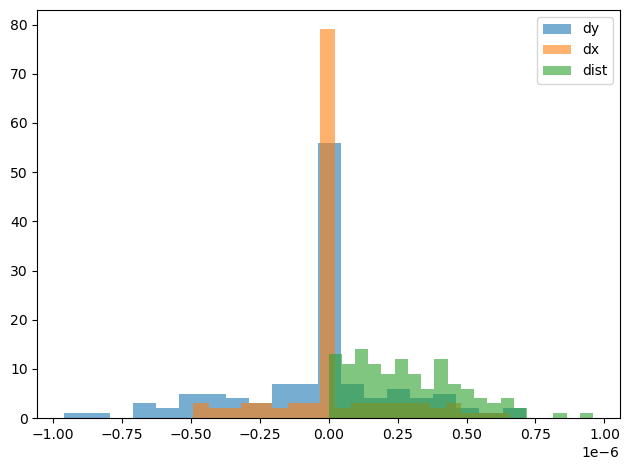

In [28]:
def get_pointings_deviation(SectorCameraCCD):
    Sector, Camera, CCD = SectorCameraCCD
    pixfile="testfiles/TEST_radec2pix_Sec{:02d}_Cam{}_CCD{}_stars2px.dat".format(Sector,Camera,CCD)
    footprint_file='footprint_input.dat'
    
    footprint_df=pd.read_csv(footprint_file,delimiter=' ',names=['tic','x','y'],index_col=False)
    final_df=pd.read_csv(pixfile,names=['tic','ra','dec','el','ela','s','c','ccd','x','y','edge'],
                         index_col=0, skiprows=16,delimiter="|" )
    
    idx = final_df.index.intersection(footprint_df.index)
    dx=final_df.loc[idx, 'x'] - footprint_df.loc[idx, 'x']
    dy=final_df.loc[idx, 'y'] - footprint_df.loc[idx, 'y']
    return dx, dy  

dx, dy  = get_pointings_deviation((1,0,0))
dist = (dx**2 + dy**2)**0.5

fig, ax = plt.subplots(1, 1, sharey=True, tight_layout=True)
ax.hist(dx,bins=20,label='dy',alpha=0.6)
ax.hist(dy,bins=20, label='dx',alpha=0.6)
ax.hist(dist,label='dist',bins=20,alpha=0.6)
plt.legend()

## Lets Check to see what input positions are recovered in our output

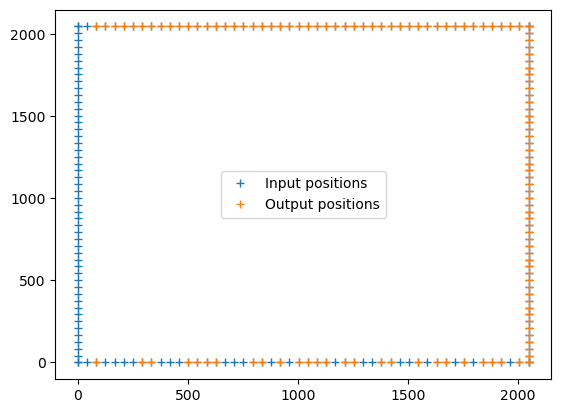

In [77]:
xy = footprint()

Sector=1
Camera=0
CCD=0

pixfile="testfiles/TEST_radec2pix_Sec{}_Cam{}_CCD{}_stars2px.dat".format(Sector,Camera,CCD)

final_df=pd.read_csv(pixfile,names=['tic','ra','dec','el','ela','s','c','ccd','x','y','edge'],
                     index_col=0, skiprows=16,delimiter="|" )

plt.plot(xy[:,0],xy[:,1],linestyle='None',marker='+',label='Input positions')
plt.plot(final_df.x, final_df.y,linestyle='None',marker='+',label='Output positions')
plt.legend()